In [1]:
import json

import geopandas as gpd
import numpy as np

from odc.stac import configure_rio, load
from pystac_client import Client as PystacClient

from utils import hls_config

In [2]:
from dask.distributed import Client as DaskClient

dask_client = DaskClient()
dask_client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 15.61 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37317,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 15.61 GiB
Comm: tcp://127.0.0.1:39153,Total threads: 1
Dashboard: http://127.0.0.1:37455/status,Memory: 3.90 GiB
Nanny: tcp://127.0.0.1:43825,


In [13]:
catalog = "https://cmr.earthdata.nasa.gov/cloudstac/LPCLOUD"

# specify Sentinel & Landsat collections
collections = ["HLSS30.v2.0", "HLSL30.v2.0"]

stac_client = PystacClient.open(catalog)

Set up query AOI

In [14]:
aoi = gpd.read_file("aoi.geojson")

aoi_geom = aoi.iloc[0].geometry

aoi.explore()

In [15]:
aoi

,name,geometry
0,main_aoi,"POLYGON ((-48.31877 -24.13236, -48.31918 -24.1..."


In [20]:
start_date = "2022-06-01"
end_date = "2023-06-01"
date_range = f"{start_date}/{end_date}"

date_range

'2022-06-01/2023-06-01'

In [21]:
items = list(stac_client.search(
             collections= collections,
             intersects = aoi_geom,
             datetime = date_range
             ).items()
)

In [22]:
type(items)

list

In [23]:
len(items)

93

In [24]:
with open("secrets.json") as f:
    data = json.load(f)
    token = data["earthdata"]["token"]

In [25]:
header_string = f"Authorization: Bearer {token}"

configure_rio(
    cloud_defaults=True,
    GDAL_HTTP_HEADERS=header_string

)

In [28]:
data = load(
    items,
    resolution=30,
    crs="EPSG:5530",
    chunks={}, #indicates that Dask will do the loading
    groupby="solar_day",
    stac_cfg=hls_config,
    bands=["red", "green", "blue","nir", "fmask"],
    geopolygon=aoi_geom
)

# lazy-loading
data

<xarray.Dataset> Size: 52MB
Dimensions:      (y: 332, x: 208, time: 84)
Coordinates:
  * y            (y) float64 3kB 7.325e+06 7.325e+06 ... 7.315e+06 7.315e+06
  * x            (x) float64 2kB 5.577e+06 5.577e+06 ... 5.583e+06 5.584e+06
    spatial_ref  int32 4B 5530
  * time         (time) datetime64[ns] 672B 2022-06-03T13:28:59.032000 ... 20...
Data variables:
    red          (time, y, x) int16 12MB dask.array<chunksize=(1, 332, 208), meta=np.ndarray>
    green        (time, y, x) int16 12MB dask.array<chunksize=(1, 332, 208), meta=np.ndarray>
    blue         (time, y, x) int16 12MB dask.array<chunksize=(1, 332, 208), meta=np.ndarray>
    nir          (time, y, x) int16 12MB dask.array<chunksize=(1, 332, 208), meta=np.ndarray>
    fmask        (time, y, x) uint8 6MB dask.array<chunksize=(1, 332, 208), meta=np.ndarray>

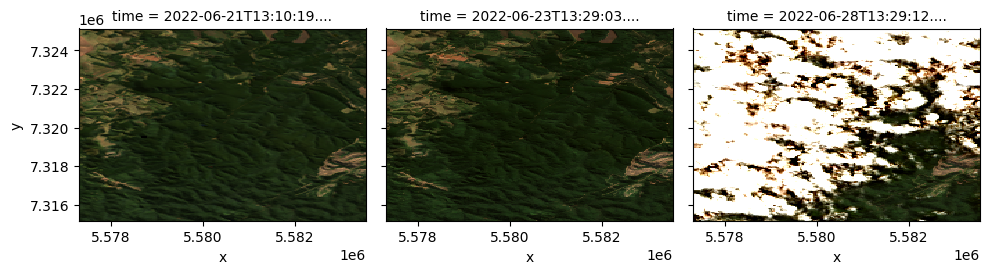

In [30]:
def plot_rgb(data):

    rgb = data[["red", "green", "blue"]]

    rgb_subset = rgb.isel(time=slice(4, 7)).to_array()

    rgb_subset.plot.imshow(
        col="time",
        col_wrap=3,
        vmin=0,
        vmax=2000
    )

plot_rgb(data)

In [33]:
def apply_cloud_mask(data):
    pq_bin = 0b00001110
    pq_mask = (data.fmask & pq_bin) != 0

    nodata_mask = data.fmask == data.fmask.odc.nodata

    mask = pq_mask | nodata_mask

    masked = data.where(~mask, other=np.nan)
    masked.drop_vars(["fmask"])

    return masked

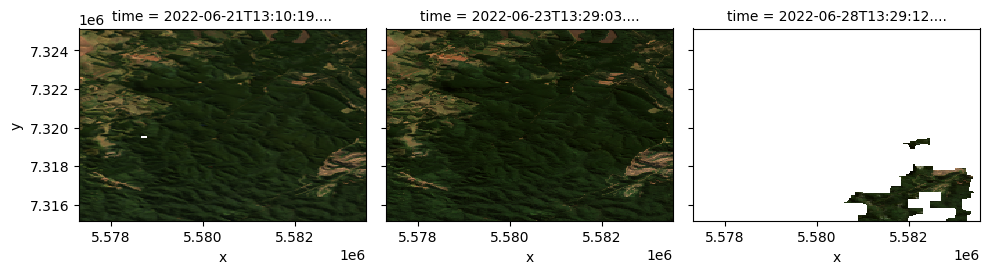

In [34]:
masked = apply_cloud_mask(data)

plot_rgb(masked)

In [36]:
def scale_offset(band):
    band = band * 0.0001
    band = band.where(band > 0, other=np.nan) # scales from integer to scale (0-1)

    return band

def calculate_evi2(data):
    nir = scale_offset(data.nir)
    red = scale_offset(data.red)

    evi2 = 2.4 * (nir - red) / (nir + red + 1)

    return evi2

masked["evi2"] = calculate_evi2(masked)

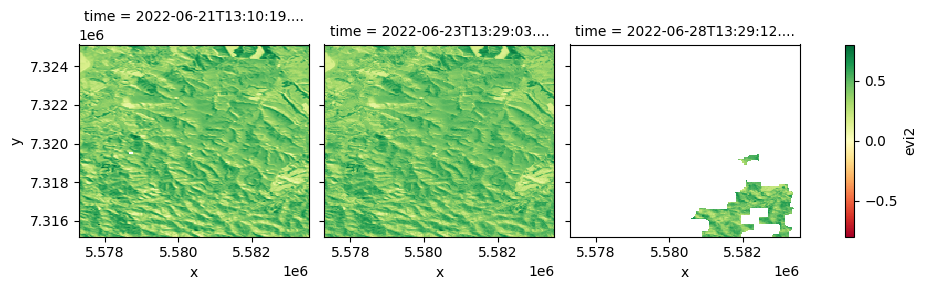

In [39]:
# function to plot evi data
def plot_evi2(data):

    evi_subset = data.evi2.isel(time=slice(4, 7))

    evi_subset.plot.imshow(
        col="time",
        col_wrap=3,
        cmap="RdYlGn"
    )

plot_evi2(masked)

In [40]:
max_values = masked.resample(time="1MS").max() #like a pd.groupby

# this is the data loading function, being applied to all scenes
max_evi2 = max_values.evi2.compute()

max_evi2

<xarray.DataArray 'evi2' (time: 12, y: 332, x: 208)> Size: 7MB
array([[[0.43870968, 0.47166562, 0.51497292, ..., 0.65395973,
         0.64733258, 0.65986059],
        [0.45743158, 0.48821549, 0.50512137, ..., 0.63243011,
         0.62656699, 0.65743691],
        [0.46547685, 0.49411765, 0.54474665, ..., 0.61589231,
         0.62656699, 0.63617553],
        ...,
        [0.432291  , 0.42240153, 0.51154691, ..., 0.35428191,
         0.25653506, 0.32791519],
        [0.38895136, 0.38589921, 0.45809829, ..., 0.39032495,
         0.2411056 , 0.30445013],
        [0.3845802 , 0.38105194, 0.41393896, ..., 0.41476252,
         0.25782354, 0.22875468]],

       [[0.50191781, 0.56465584, 0.6137754 , ..., 0.60537466,
         0.60616158, 0.6206867 ],
        [0.52850269, 0.5901749 , 0.6205171 , ..., 0.60747462,
         0.60039077, 0.62103163],
        [0.53342703, 0.56608253, 0.63206804, ..., 0.58704028,
         0.60039077, 0.59190953],
...
        [0.50360353, 0.49369314, 0.55206243, ..., 0.49073246,
         0.3910355 , 0.46068228],
        [0.46827435, 0.45178473, 0.49300393, ..., 0.55203216,
         0.39922027, 0.42892067],
        [0.49615563, 0.46300619, 0.48089365, ..., 0.55942523,
         0.454167  , 0.41464752]],

       [[0.53695473, 0.59842258, 0.57446721, ..., 0.28782193,
         0.28253558, 0.28386365],
        [0.46886589, 0.56994465, 0.55206452, ..., 0.28844483,
         0.28904537, 0.28627648],
        [0.45006209, 0.5365484 , 0.54859521, ..., 0.288     ,
         0.28904537, 0.29253947],
        ...,
        [0.47197437, 0.46852141, 0.54489293, ..., 0.42029334,
         0.33136375, 0.39677025],
        [0.45657427, 0.43544142, 0.49823159, ..., 0.47820882,
         0.31036606, 0.36854379],
        [0.45250415, 0.42973621, 0.46077739, ..., 0.49124971,
         0.33640716, 0.31524645]]])
Coordinates:
  * y            (y) float64 3kB 7.325e+06 7.325e+06 ... 7.315e+06 7.315e+06
  * x            (x) float64 2kB 5.577e+06 5.577e+06 ... 5.583e+06 5.584e+06
    spatial_ref  int32 4B 5530
  * time         (time) datetime64[ns] 96B 2022-06-01 2022-07-01 ... 2023-05-01

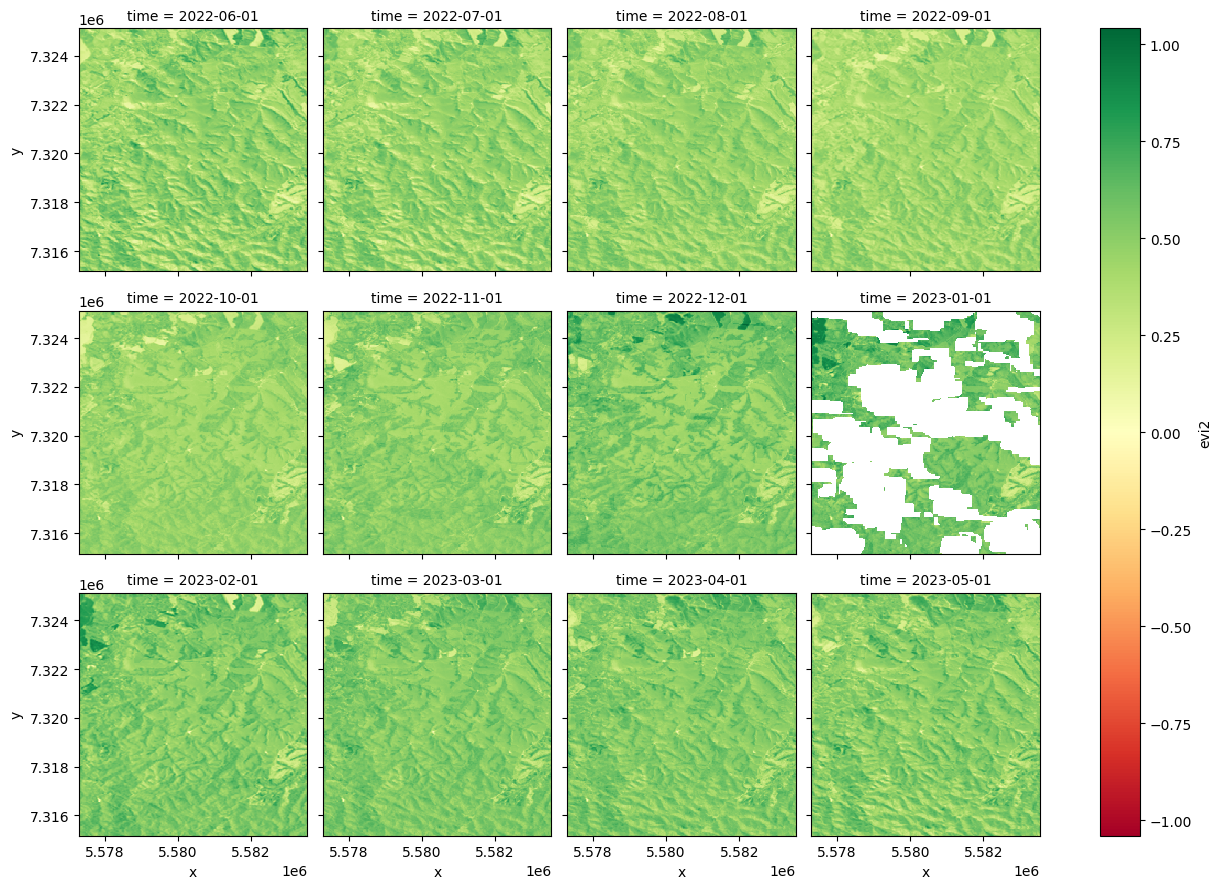

In [41]:
max_evi2.plot.imshow(
    col="time",
    col_wrap=4,
    cmap="RdYlGn"
)

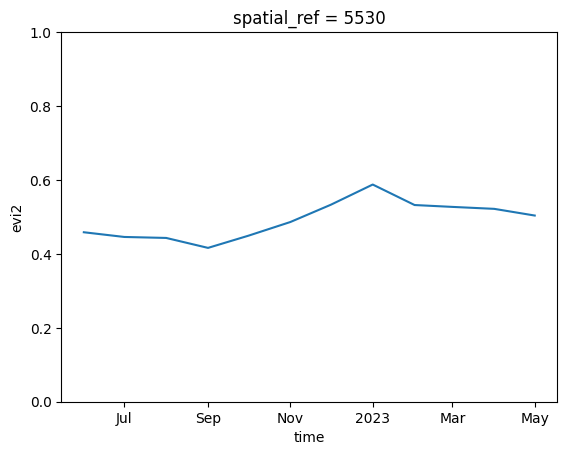

In [42]:
max_evi2.mean(["x", "y"]).plot(ylim=(0,1))

`ctrl + space` shows tooltips for python functions

`Part 3`

In [44]:
year_range = range(2013, 2024)

peak_vegetation_items = []

for year in year_range:
    start_date = f"{year}-12-01"
    end_date = f"{year+1}-02-28"
    date_range = f"{start_date}/{end_date}"

    # Search for items in the collection
    items = list(
        stac_client.search(
            collections=collections,
            intersects=aoi_geom,
            datetime=date_range
        ).items()
    )

    peak_vegetation_items.extend(items)

len(peak_vegetation_items)



159

In [45]:
trend_data = load(
    peak_vegetation_items,
    resolution=30,
    crs="EPSG:5530",
    chunks={}, #indicates that Dask will do the loading
    groupby="solar_day",
    stac_cfg=hls_config,
    bands=["red", "green", "blue","nir", "fmask"],
    geopolygon=aoi_geom
)

In [46]:
trend_data_masked = apply_cloud_mask(trend_data)

trend_data_masked["evi2"] = calculate_evi2(trend_data_masked)

Resample into 3 monthly periods

In [47]:
quarters_max = trend_data_masked.resample(time="QS-DEC").max()

dec_quarters_max = quarters_max.sel(
    time=quarters_max.time.dt.month == 12
)

dec_quarters_max_evi2 = dec_quarters_max.evi2.compute()

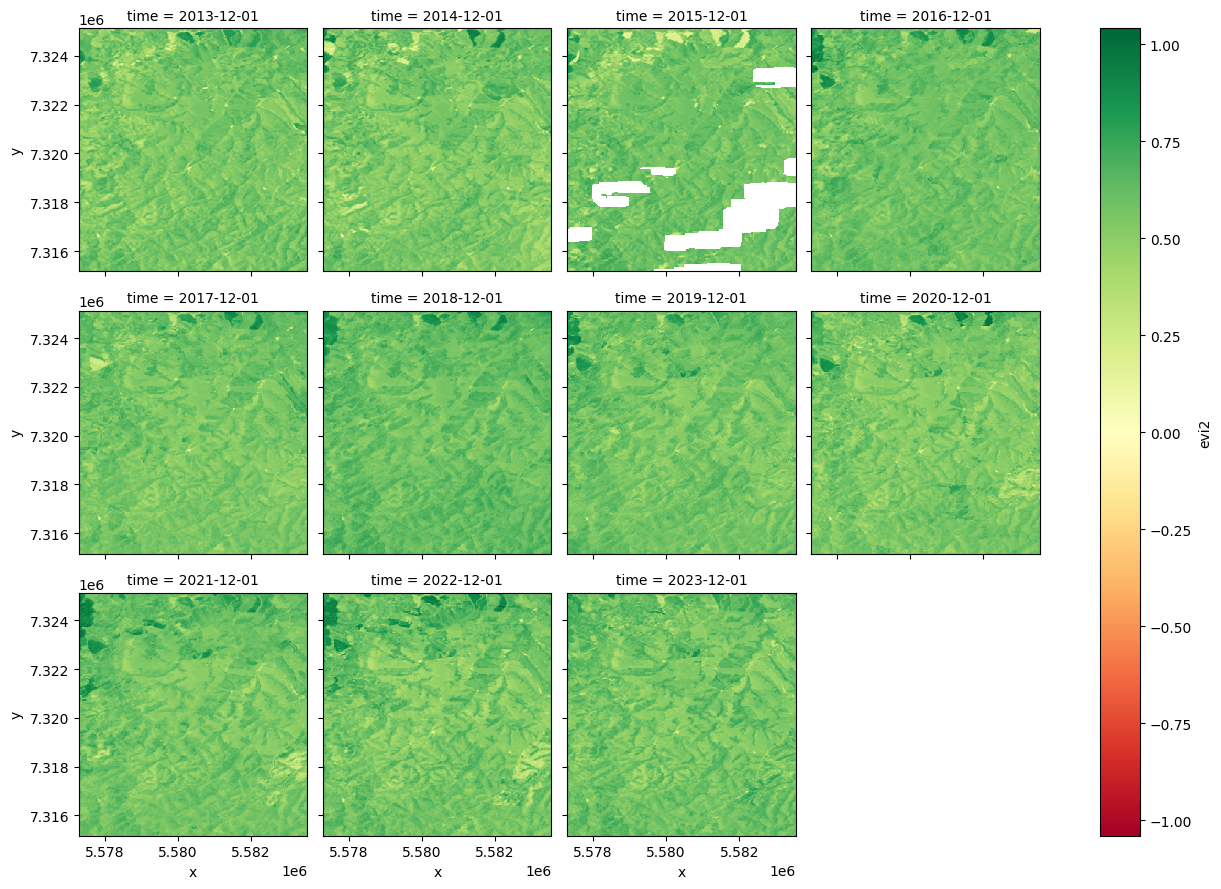

In [48]:
dec_quarters_max_evi2.plot.imshow(
    col="time",
    col_wrap=4,
    cmap="RdYlGn"
)

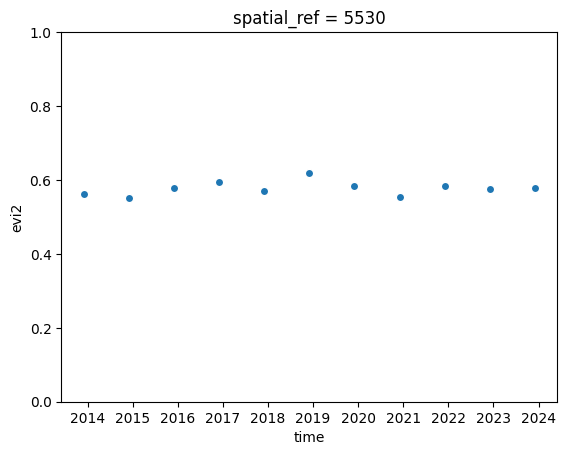

In [50]:
annual_max_evi2 = dec_quarters_max_evi2.mean(["x", "y"])
annual_max_evi2.plot.scatter(ylim=(0,1))